In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.stats import norm
import jax_cosmo as jc

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import seaborn as sns
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty.utils import resample_equal

from tqdm import tqdm
from matplotlib.lines import Line2D
np.random.seed(42)


catalog_filename = "/Users/maddycrossparkin/Downloads/16651.csv.bz2"
chunksize = 10000
chunks = []

columns_needed = ['ra', 'dec', 'z', 'abs_mag_r']
for chunk in pd.read_csv(catalog_filename, sep=",", comment='#', na_values=r'\N', compression='bz2', chunksize=chunksize, usecols = columns_needed):
    chunks.append(chunk)

data_MICECAT = pd.concat(chunks, ignore_index=True)
data_MICECAT = data_MICECAT.sort_values('z')

catalog_filename = "/Users/maddycrossparkin/Downloads/22495.csv.bz2"
chunksize = 10000
chunks = []
columns_needed = ['r_des_true', 'i_des_true', 'g_des_true', 'z']
for chunk in pd.read_csv(catalog_filename, sep=",", comment='#', na_values=r'\N', compression='bz2', chunksize=chunksize, usecols = columns_needed):
    chunks.append(chunk)

data_MICECAT_mags = pd.concat(chunks, ignore_index=True)
data_MICECAT_mags = data_MICECAT_mags.sort_values(by=['z'])


data_MICECAT['r_des_true'] = data_MICECAT_mags['r_des_true']
data_MICECAT['i_des_true'] = data_MICECAT_mags['i_des_true']
data_MICECAT['g_des_true'] = data_MICECAT_mags['g_des_true']
data_MICECAT = data_MICECAT[data_MICECAT['z'] <= 0.7]

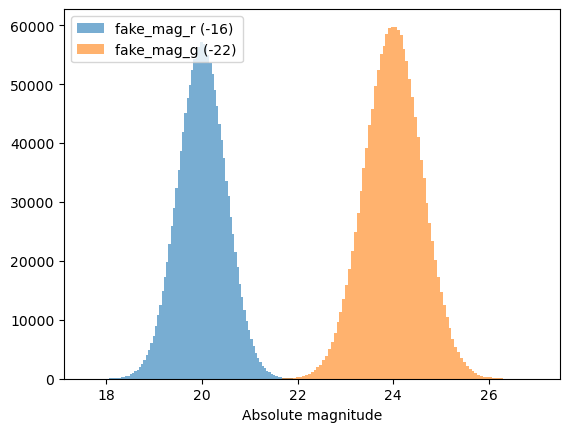

In [ ]:

N = len(data_MICECAT)

# fake absolute magnitudes
mu_r, sigma_r = 20.0, 0.5   # faint population
mu_g, sigma_g = 24.0, 0.6   # bright population

data_MICECAT["fake_mag_r"] = np.random.normal(mu_r, sigma_r, N)
data_MICECAT["fake_mag_g"] = np.random.normal(mu_g, sigma_g, N)

import matplotlib.pyplot as plt

plt.hist(data_MICECAT["fake_mag_r"], bins=100, alpha=0.6, label="fake_mag_r (-16)")
plt.hist(data_MICECAT["fake_mag_g"], bins=100, alpha=0.6, label="fake_mag_g (-22)")
plt.xlabel("Absolute magnitude")
plt.legend()
plt.show()
        

In [ ]:
jax.config.update("jax_enable_x64", True)


key = jax.random.PRNGKey(42)
speed_of_light = 299792.458
Om0 = 0.25

true_cosmology = FlatLambdaCDM(H0=70., Om0=Om0)

def dL_at_z_H0(z_array, H0, Om0):
    """Compute luminosity distance d_L(z) for a given redshift array and cosmology (H0, Om0) (JAX friendly)"""
    c = 299792.458 

    def H_z(z):
        return H0 * jnp.sqrt(Om0 * (1 + z)**3 + (1 - Om0))

    def comoving_distance(z):
        z_grid = jnp.linspace(0, z, 100) 
        integrand = c / H_z(z_grid)
        return jnp.trapezoid(integrand, z_grid)

    if jnp.ndim(z_array) == 0:
        D_C = comoving_distance(z_array)
        d_L = (1 + z_array) * D_C
        return d_L
    else:
        D_C_array = jax.vmap(comoving_distance)(z_array)
        d_L_array = (1 + z_array) * D_C_array
        return d_L_array


def z_at_dL_H0(dL_target, Om0, H0, zinterp):
    """Invert d_L(z) relation to estimate z for a given luminosity distance via interpolation."""
    dL_grid = dL_at_z_H0(zinterp, H0, Om0)
    idx = jnp.argsort(dL_grid)
    dL_sorted = dL_grid[idx]
    z_sorted = zinterp[idx]
    z_est = jnp.interp(dL_target, dL_sorted, z_sorted)
    return z_est

def E(z, Om):
    """Dimensionless Hubble parameter E(z) = H(z)/H0."""
    return jnp.sqrt(Om*(1+z)**3 + (1-Om))


def dL_by_z_H0(z,dL,h0,Om0):
    """Compute derivative dL/dz under a flat ΛCDM model."""
    return dL/(1+z) + speed_of_light*(1+z)/(h0*E(z,Om0))


def dvdz_jax(z, H0, Om0):
    """Compute comoving volume element dV/dz (in Mpc3) (JAX friendly)."""
    c = 299792.458
    H_z = H0 * jnp.sqrt(Om0 * (1 + z)**3 + (1 - Om0))
    def comoving_distance(z_val):
        z_grid = jnp.linspace(0, z_val, 200)
        integrand = c / (H0 * jnp.sqrt(Om0 * (1 + z_grid)**3 + (1 - Om0)))
        return jnp.trapezoid(integrand, z_grid)

    chi = jax.vmap(comoving_distance)(z)
    dvdz = 4 * jnp.pi * (c / H_z) * chi**2
    return dvdz


def prepare_mice_data(data, loc_area, direction):
    ra, dec = direction
    """Filter MICEcat within a circular localisation area of given area around (ra, dec)."""
    radius = np.sqrt(loc_area/np.pi)
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    
    angular_distance = np.arccos(np.sin(np.radians(data['dec'])) * np.sin(dec_rad) + np.cos(np.radians(data['dec'])) * np.cos(dec_rad) * np.cos(np.abs(np.radians(data['ra']) - ra_rad)))
    angular_distance_deg = np.degrees(angular_distance)
    filtered_data = data[angular_distance_deg <= radius]
        
    return filtered_data

def draw_gw_events_phost(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate, f = 0):
    np.random.seed(42)
    Ngw=100000
    eligible = galaxies_list[galaxies_list['z'] <= zcut_rate]
    
    z_arr   = eligible['z'].to_numpy()
    dL_true = true_cosmology.luminosity_distance(z_arr).to('Mpc').value  # [Mpc]

    
    m_r = eligible['fake_mag_r'].to_numpy()
    M_r = m_r - 5*np.log10(dL_true) - 25.0
    L_r = np.nan_to_num(3.0128e28 * 10**(-0.4 * M_r))
    p_host_r = L_r / np.sum(L_r)
    
    m_g = eligible['fake_mag_g'].to_numpy()
    M_g = m_g - 5*np.log10(dL_true) - 25.0
    L_g = np.nan_to_num(3.0128e28 * 10**(-0.4 * M_g))
    p_host_g = L_g / np.sum(L_g)
     
    p_host = f * p_host_r + (1 - f) * p_host_g
   
    chosen_idx = np.random.choice(eligible.index, size=Ngw, replace=True, p=p_host)
    chosen_galaxies = eligible.loc[chosen_idx]
    
    gw_redshift = chosen_galaxies['z'].to_numpy()
    gw_true_ra = chosen_galaxies['ra'].to_numpy()
    gw_true_dec = chosen_galaxies['dec'].to_numpy()
    gw_true_dl = true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value

    std_dl = gw_true_dl * sigma_dl
    gw_obs_dl = np.random.randn(len(gw_true_dl)) * std_dl + gw_true_dl
    
    gw_detected =np.arange(Ndet)#np.where(gw_obs_dl < dl_thr)[0][:Ndet]

    return  gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected], std_dl[gw_detected], gw_true_ra[gw_detected], gw_true_dec[gw_detected], chosen_idx[gw_detected]
        
        
def random_directions(data):
    """Generate a random sky direction (ra, dec) within the bounds of a catalog."""
    randomdirections = []
    minra, maxra = np.min(data['ra']), np.max(data['ra'])
    mindec, maxdec = np.min(data['dec']), np.max(data['dec'])
    randra = np.random.uniform(minra, maxra)
    randdec = np.random.uniform(mindec, maxdec)
    randomdirections.append((randra, randdec))
    return randomdirections

def gen_dlposterior_samples(Nsamples, dl_true, sigma_dl):
    """Generate posterior samples of luminosity distance given true dL and uncertainty."""
    sigma_dL = sigma_dl * dl_true
    samples = jax.random.normal(key, shape=(Nsamples,)) * sigma_dL + dl_true
    return samples
   
def sample_ra_dec_from_area_circular(ra_center_deg, dec_center_deg, area_deg2, Nsamples):
    """Sample random (RA, Dec) positions in a Gaussian localisation area area centered on (ra_center, dec_center)."""
    key_x, key_y = jax.random.split(key)
    sigma_deg = np.sqrt(area_deg2 / (-2.0 * np.pi * np.log(1.0 - 0.95)))

    x = jax.random.normal(key_x, shape=(Nsamples,)) * sigma_deg
    y = jax.random.normal(key_y, shape=(Nsamples,)) * sigma_deg

    dec0_rad = jnp.deg2rad(dec_center_deg)
    cos_dec0 = jnp.clip(np.cos(dec0_rad), 1e-6, 1.0)
    dra_deg  = x / cos_dec0
    ddec_deg = y

    ra_deg  = (ra_center_deg + dra_deg) % 360.0
    dec_deg = jnp.clip(dec_center_deg + ddec_deg, -90.0, 90.0)

    return jnp.deg2rad(ra_deg), jnp.deg2rad(dec_deg)

def puniverse(event, raobs, decobs, zobs, H0, f):
    zgal = event["z"]
    dL = dL_at_z_H0(zgal, H0, Om0)
    rmag, imag = event["fake_mag_r"], event["fake_mag_g"]

    mags = jnp.stack([rmag, imag])
    fluxes = jnp.nan_to_num(3.0128e28 * 10**(-0.4*(mags - 5*jnp.log10(dL) - 25)))

    weights = fluxes / jnp.sum(fluxes, axis=1, keepdims=True)

    prob_ra  = norm.pdf(raobs[:, None], event["ra_mean"][None, :], event["ra_sigma"][None, :])
    prob_dec = norm.pdf(decobs[:, None], event["dec_mean"][None, :], event["dec_sigma"][None, :])
    prob_z   = norm.pdf(zobs[:, None],  event["z_mean"][None, :],  event["z_sigma"][None, :])

    w_mix = f*weights[0] + (1-f)*weights[1]
    p_matrix = w_mix[None, :] * prob_ra * prob_dec * prob_z
    return p_matrix / event["ra_mean"].size

def prior_transform_f(theta):
    f_min, f_max = 0, 1
    f_ = theta
    f = f_*(f_max-f_min) + f_min
    return f
    
def prior_transform_H0(theta):
    H0_min, H0_max = 5, 220
    H0_ = theta
    H0 = H0_*(H0_max-H0_min) + H0_min
    return H0

def log_likelihood_event(theta, event, zinterp, fixed):
    if fixed is None:
        H0, f = theta
    elif fixed == "H0":
        f = theta
        H0 = 70.0
    elif fixed == "f":
        H0 = theta
        f = 0.
    else:
        raise ValueError("fixed must be 'H0' or 'f'")

    zobs = z_at_dL_H0(event["dLobs"], Om0, H0, zinterp)
    #weights = (dvdz_jax(zobs, H0, Om0) / dL_by_z_H0(zobs, event["dLobs"], H0, Om0) / (1 + zobs) / event["dLobs"]**2 / jnp.cos(event["decobs"]))
    weights = (dvdz_jax(zobs, H0, Om0) / dL_by_z_H0(zobs, event["dLobs"], H0, Om0) / (1 + zobs) / 1/ jnp.cos(event["decobs"]))

    p_matrix = puniverse(event, event["raobs"], event["decobs"], zobs, H0, f)
    weights_0 = jnp.sum(p_matrix * weights[:, None], axis=1)

    return jnp.log(jnp.mean(weights_0)) #- 3 * jnp.log(H0)


def log_likelihood_combined(theta, dirs_data, zinterp, fixed):
    fn = lambda e: log_likelihood_event(theta, e, zinterp, fixed)
    return jnp.sum(jnp.array([fn(e) for e in dirs_data]))

def grid_loglike(theta_grid, dirs_data, zinterp, fixed):
    logL = []
    for theta in tqdm(theta_grid):
        logL.append(
            log_likelihood_combined(theta, dirs_data, zinterp, fixed)
        )
    return jnp.array(logL)



In [ ]:
#generating the apex of each cone that defines each localisation area
dirs = []
for i in tqdm(range(1000)):
    dirs.extend(random_directions(data_MICECAT)) 

100%|██████████| 1000/1000 [00:02<00:00, 367.47it/s]


  0%|          | 0/100 [00:00<?, ?it/s]/Users/maddycrossparkin/miniconda3/envs/maddyenv_local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/Users/maddycrossparkin/miniconda3/envs/maddyenv_local/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


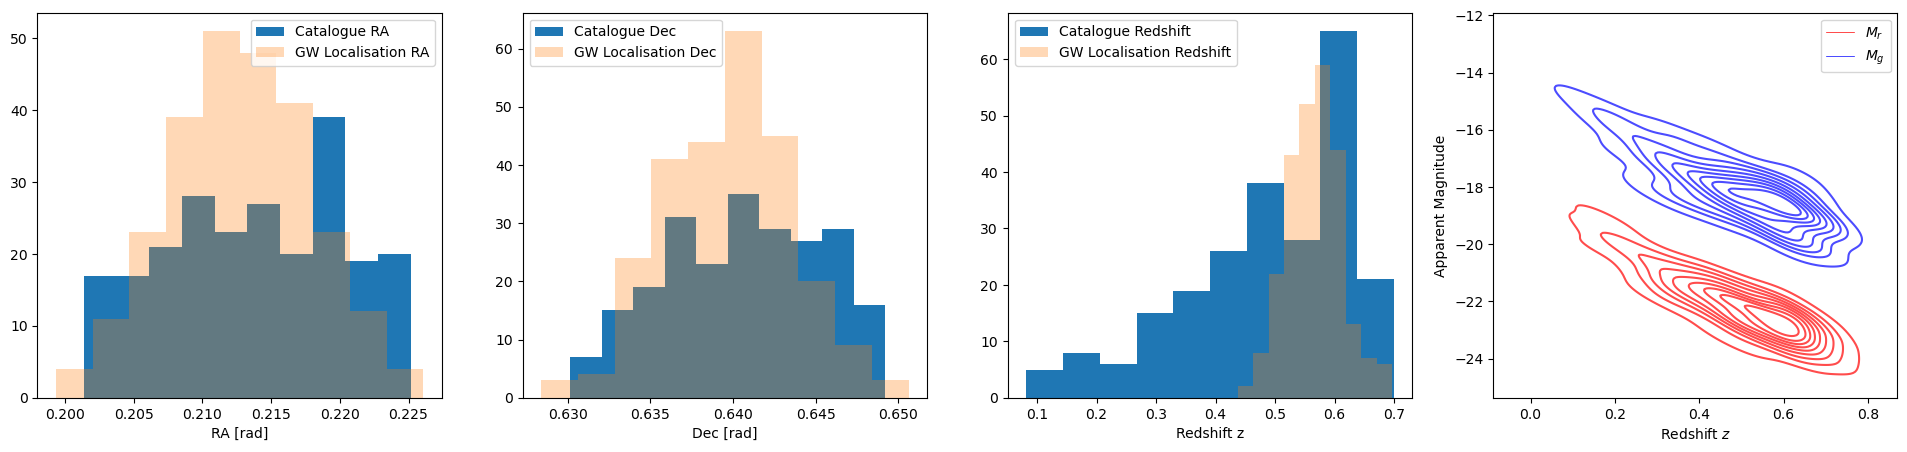

100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


In [ ]:
loc = 1
sigma_zi = 1e-2
sigma_dL = 0.1
sigma_dec = 0.01
sigma_ra = 0.01
dl_thr = 1550
Nsamples = 256
dirs_data = []


zinterp = np.linspace(0,0.7,5000)

for ind, direction in enumerate(tqdm(dirs[0:100])):
    redshift_data_MICE = prepare_mice_data(data_MICECAT, loc, direction)
    z = redshift_data_MICE['z'].to_numpy()
    ra = np.deg2rad(redshift_data_MICE['ra'].to_numpy())
    dec = np.deg2rad(redshift_data_MICE['dec'].to_numpy())
    dz = sigma_zi*z

    raobs, decobs = sample_ra_dec_from_area_circular((direction[0]), (direction[1]), loc, Nsamples)

    gw_obs_dl, gw_true_dl, gw_redshift, std_dl, ra_gw, dec_gw, _ = draw_gw_events_phost(Ndet=1, sigma_dl=sigma_dL, dl_thr=dl_thr, galaxies_list=redshift_data_MICE, true_cosmology=true_cosmology, zcut_rate=0.7)
    dLobs = gen_dlposterior_samples(Nsamples, gw_true_dl, sigma_dL)
    zobs = z_at_dL_H0(dLobs, Om0, 70, zinterp)

    if ind == 0:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5))
        ax1.hist(ra, label = "Catalogue RA")
        ax1.hist(raobs, alpha = 0.3, label = "GW Localisation RA")
        ax1.set_xlabel('RA [rad]')
        ax2.hist(dec, label = "Catalogue Dec")
        ax2.hist(decobs, alpha = 0.3, label = "GW Localisation Dec")
        ax2.set_xlabel('Dec [rad]')
        ax3.hist(z, label = "Catalogue Redshift")
        ax3.hist(zobs, alpha = 0.3, label = "GW Localisation Redshift")
        ax3.set_xlabel('Redshift z')
        ax1.legend()
        ax2.legend()
        ax3.legend()
        
        m_r = redshift_data_MICE['fake_mag_r'].to_numpy()
        m_g = redshift_data_MICE['fake_mag_g'].to_numpy()
        m_i = redshift_data_MICE['i_des_true'].to_numpy()
        
        dL_true = true_cosmology.luminosity_distance(z).to('Mpc').value
        
        M_r = m_r - 5*np.log10(dL_true) - 25.0
        L_r = np.nan_to_num(3.0128e28 * 10**(-0.4 * M_r))
        
        M_g = m_g - 5*np.log10(dL_true) - 25.0
        L_g = np.nan_to_num(3.0128e28 * 10**(-0.4 * M_g))
        
        M_i = m_i - 5*np.log10(dL_true) - 25.0
        L_i = np.nan_to_num(3.0128e28 * 10**(-0.4 * M_i))
        #sns.kdeplot(x=z, y= redshift_data_MICE['r_des_true'], fill=False, color="red", ax=ax4)
        #sns.kdeplot(x=z, y= redshift_data_MICE['g_des_true'], fill=False, color="blue", ax=ax4)
    
        sns.kdeplot(x=z, y= M_r, fill=False, color="red", ax=ax4, lw = 0.5, alpha =0.7)
        sns.kdeplot(x=z, y= M_g, fill=False, color="blue", ax=ax4, lw = 0.5, alpha =0.7)
        #sns.kdeplot(x=z, y= M_i, fill=False, color="green", ax=ax4, lw = 0.5, alpha =0.7)

        ax4.set_xlabel(r"Redshift $z$")
        ax4.set_ylabel("Apparent Magnitude")
        
        custom_lines = [
        Line2D([0], [0], color="red", lw=0.5),
        Line2D([0], [0], color="blue", lw=0.5),
        Line2D([0], [0], color="green", lw=0.5)]
        ax4.legend(custom_lines, [r"$M_r$", r"$M_g$"])
    
        plt.show()
        
    
    dirs_data.append({
        "raobs": jnp.asarray(raobs),
        "decobs": jnp.asarray(decobs),
        "dLobs": jnp.asarray(dLobs),
        "z": jnp.asarray(z),
        
        "fake_mag_r": jnp.asarray(redshift_data_MICE['fake_mag_r'].to_numpy()),
        "fake_mag_g": jnp.asarray(redshift_data_MICE['fake_mag_g'].to_numpy()),
        
        "ra_mean": ra,
        "ra_sigma": jnp.full_like(ra, sigma_ra),
        "dec_mean": dec,
        "dec_sigma": jnp.full_like(dec, sigma_dec),
        "z_mean": z,
        "z_sigma": dz
    })